# BEE 4750 Sea Level Rise Linear Program

**Name**: floating sigmas



## Setup

below are the necessary packages. this code will
1. take in a value for flooding
2. output an optimal solution for the municipality.


In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/4750coding/SLR-LP-4750`


In [2]:
using JuMP # optimization modeling syntax
using HiGHS # optimization solver

## Overview
The goal is to 

## Exercise (3 points)


| Flood protection Type | Price/unit | BUildings protected per  |
|:-------------:|:----------------------:|:--------------------:|
|        Dry Installation     |   15,000 per building    |         1          |
|       Wet installation      |   5,000    |         1          |
|       Dyke       |    10million perlength perheight  |                   |



objective - minimize buildings lost

variables - how much of each flood proofing to install (A B and C) ((will find real examples later))

constraints - cannot go over the budget



In [3]:
using JuMP
using HiGHS  # HiGHS solver for linear programming

# Import required packages
using JuMP
using HiGHS

# Define parameters
c2 = 15_000        # Cost per wet installation
c3 = 5_000_000    # Cost of 1 m-high dyke per km
d = 200_000       # Damage cost per unprotected house
h = 300           # Total number of houses
p = 100           # Number of houses protected per km of dyke
budget = 4.5e6        #VARIABLE budget
inputSLR = .5      #VARIABLE from cella
maxSLR = 1        #VARIABLE actuallyFindThisValue
houseDestructionPerc = (inputSLR/maxSLR) #use this percentage for amount of housing lost.
dykeHeight = 1      #assume installed dyke must be 1m

# Create a model with HiGHS optimizer
model = Model(HiGHS.Optimizer)

# Define decision variables
@variable(model, x2 >= 0, Int)  # Number of wet installations
@variable(model, x3 >= 0)       # length of dyke in km



# Define the objective function
#cost*amt for each thingy, adjust damage cost function based on how much damage the house takes
@objective(model, Min, 
     c2 * x2 + (c3 * x3) + #upfront cost
     houseDestructionPerc * d * (h - ( x2 + p * x3)) + #damage cost of untreated houses
     x2*.2*houseDestructionPerc * d #damage cost of wet treated houses
)

# Add constraints
@constraint(model, x2 + p * x3 <= h)  # Protection cannot exceed total houses
@constraint(model, c2*x2 + c3*x3 <= budget)  #town budget constraint


# Solve the model
optimize!(model)

# Check and display results
if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found:")
    println("Number of wet installations (x2): ", value(x2))
    println("Length of dyke (x3): ", value(x3), " meters")
    println("2100 Minimum cost: \$", objective_value(model))

    upfront_cost = c2 * value(x2) + c3 * value(x3) #find the cost in 2030 (itll prob be budget until budget is v high then level)
    println("2030 upfront cost: \$", upfront_cost)


else
    println("No optimal solution found. Status: ", termination_status(model))
end






Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 5e+06]
  Cost   [6e+04, 5e+06]
  Bound  [0e+00, 0e+00]
  RHS    [3e+02, 4e+06]
Presolving model
2 rows, 2 cols, 4 nonzeros  0s
2 rows, 2 cols, 4 nonzeros  0s

Solving MIP model with:
   2 rows
   2 cols (0 binary, 1 integer, 0 implied int., 1 continuous)
   4 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   6000000         inf                  inf        0      0      0         0     0.0s

Solving report
  Status            Optimal
  Primal bound      10500000
  Dual bound        10500000
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    10500000 (objective)
                    

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 5e+06]
  Cost   [2e+04, 2e+04]
  Bound  [0e+00, 0e+00]
  RHS    [3e+02, 3e+02]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      15000000
  Dual bound        15000000
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    15000000 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.00 (total)
                    0.00 (presolve)
                    0.00 (postsolve)
  Nodes             0
  LP iterations     0 (total)
                    0 (strong br.)
                    0 (separation)
                    0 (heuristics)
Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
 

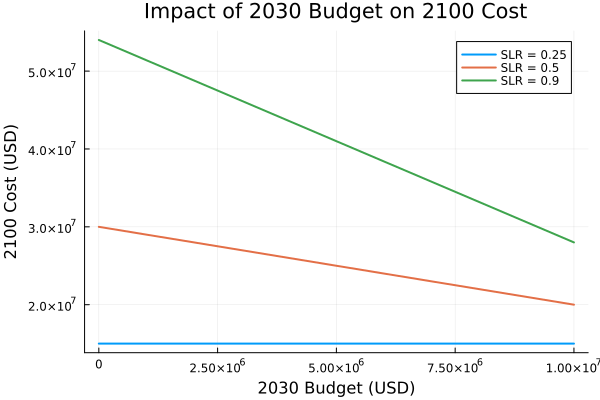

In [4]:
using JuMP
using HiGHS
using Plots

# Define parameters
c2 = 15_000        # Cost per wet installation
c3 = 5_000_000     # Cost of 1 m-high dyke per km
d = 200_000        # Damage cost per unprotected house
h = 300            # Total number of houses
p = 100            # Number of houses protected per km of dyke
maxSLR = 1         # Maximum sea level rise
dykeHeight = 1     # Dyke height in meters

# Define budgets and SLR scenarios
budgets = 0:1e6:10e6  # 2030 budgets from 0 to 10 million in 1 million steps
inputSLRs = [0.25, 0.5, 0.9]  # SLR scenarios to evaluate
results = Dict()  # To store results for each SLR scenario

# Loop over SLR scenarios
for inputSLR in inputSLRs
    # Calculate the percentage of houses destroyed
    houseDestructionPerc = inputSLR / maxSLR

    # Storage for results for this SLR scenario
    costs_2100 = Float64[]

    # Loop over budgets
    for budget in budgets
        # Create a new model for each budget
        model = Model(HiGHS.Optimizer)

        # Define decision variables
        @variable(model, x2 >= 0, Int)  # Number of wet installations
        @variable(model, x3 >= 0)       # Length of dyke in km

        # Define the objective function
        @objective(
            model, Min,
            c2 * x2 + c3 * x3*h3 +                               # Upfront cost
            houseDestructionPerc * d * (h - (x2 + p * x3)) +  # Damage cost of untreated houses
            x2 * 0.2 * houseDestructionPerc * d              # Damage cost of wet-treated houses
        )

        # Add constraints
        @constraint(model, x2 + p * x3 <= h)               # Protection cannot exceed total houses
        @constraint(model, c2 * x2 + c3 * x3 <= budget)    # Budget constraint

        # Solve the model
        optimize!(model)

        # Store the cost if the solution is optimal
        if termination_status(model) == MOI.OPTIMAL
            push!(costs_2100, objective_value(model))
        else
            push!(costs_2100, NaN)  # Use NaN for infeasible solutions
        end
    end

    # Store the results for this SLR scenario
    results[inputSLR] = costs_2100
end

# Plot the results
plot(
    budgets, results[0.25],
    label = "SLR = 0.25",
    xlabel = "2030 Budget (USD)",
    ylabel = "2100 Cost (USD)",
    title = "Impact of 2030 Budget on 2100 Cost",
    lw = 2
)
plot!(
    budgets, results[0.5],
    label = "SLR = 0.5",
    lw = 2
)
plot!(
    budgets, results[0.9],
    label = "SLR = 0.9",
    lw = 2
)


BELOW IS JUST DiKE W VARIABILITY

In [10]:
using JuMP
using HiGHS  # HiGHS solver for linear programming

# Import required packages
using JuMP
using HiGHS

# Define parameters
c3 = 5_000_000    # Cost of 1 m-high dike per km
d = 200_000       # Damage cost per unprotected house
h = 300           # Total number of houses
p = 100           # Number of houses protected per km of dike
budget = 2.5e6        #VARIABLE budget
inputSLR = .6      #VARIABLE from cella
maxSLR = 1        #VARIABLE actuallyFindThisValue
houseDestructionPerc = (inputSLR/maxSLR) #use this percentage for amount of housing lost.
h3 = .6     #assume installed dike must be 1m

# Create a model with HiGHS optimizer
model = Model(HiGHS.Optimizer)

        # Define decision variable
        @variable(model, x3 >= 0)       # Length of dike in km

        # Define the objective function
        @objective(
            model, Min,
            c3 * x3 * h3 +                               # Upfront cost DiKE
            houseDestructionPerc * d * (h - (p * x3))  # Damage cost of untreated houses
        )

        # Add constraints
        @constraint(model, p * x3 <= h)               # Protection cannot exceed total houses
        @constraint(model, c3 * x3 * h3 <= budget)    # Budget constraint

        # Solve the model
        optimize!(model)

# Check and display results
if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found:")
    println("Number of wet installations (x2): ", value(x2))
    println("Length of dike (x3): ", value(x3), " meters")
    println("2100 Minimum cost: \$", objective_value(model))

    upfront_cost = c3 * value(x3) #find the cost in 2030 (itll prob be budget until budget is v high then level)
    println("2030 upfront cost: \$", upfront_cost)


else
    println("No optimal solution found. Status: ", termination_status(model))
end






Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+02, 3e+06]
  Cost   [9e+06, 9e+06]
  Bound  [0e+00, 0e+00]
  RHS    [3e+02, 2e+06]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-2); columns 0(-1); elements 0(-2) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  2.8500000000e+07
HiGHS run time      :          0.00
Optimal solution found:
Number of wet installations (x2): -0.0
Length of dyke (x3): 0.8333333333333334 meters
2100 Minimum cost: $2.85e7
2030 upfront cost: $4.166666666666667e6


Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+02, 7e+06]
  Cost   [2e+07, 2e+07]
  Bound  [0e+00, 0e+00]
  RHS    [3e+02, 3e+02]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-2); columns 0(-1); elements 0(-2) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  9.6666666667e+07
HiGHS run time      :          0.00
Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+02, 7e+06]
  Cost   [2e+07, 2e+07]
  Bound  [0e+00, 0e+00]
  RHS    [3e+02, 1e+06]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-2); columns 0(-1); elements 0(-2) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Object

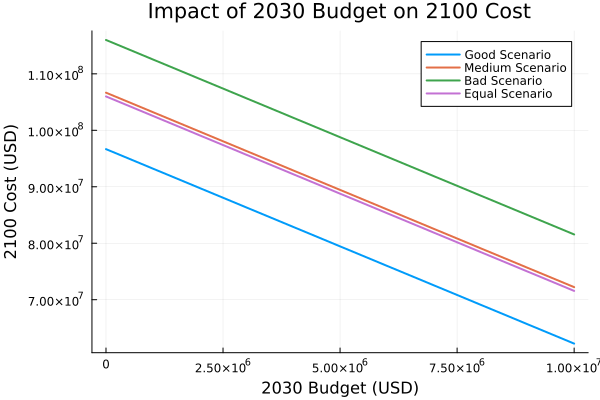

In [2]:
using JuMP
using HiGHS
using Plots

# Define parameters
c3 = 5_000_000     # Cost of 1 m-high dike per km
d = 200_000        # Damage cost per unprotected house
h = 300            # Total number of houses
p = 100            # Number of houses protected per km of dike
maxSLR = .9         # VARIABLE FROM CELLA Maximum sea level rise

#@@@@@@@@@@@@@@@@@@@@@
#INPUTS FROM SLR PROJECTIONS
i1 = 1.45
i2 = 1.60
i3 = 1.74
i4 = 1.59
#@@@@@@@@@@@@@@@@@@@@@

# Define budgets and SLR scenarios
budgets = 0:1e6:10e6  # 2030 budgets from 0 to 10 million in 1 million steps
inputSLRs = [i1, i2, i3, i4]  # SLR scenarios to evaluate 
results = Dict()  # To store results for each SLR scenario

# Loop over SLR scenarios
for inputSLR in inputSLRs
    h3 = inputSLR     # Dike height in meters

    # Calculate the percentage of houses destroyed
    houseDestructionPerc = inputSLR / maxSLR

    # Storage for results for this SLR scenario
    costs_2100 = Float64[]

    # Loop over budgets
    for budget in budgets
        # Create a new model for each budget
        model = Model(HiGHS.Optimizer)

        # Define decision variable
        @variable(model, x3 >= 0)       # Length of dike in km

        # Define the objective function
        @objective(
            model, Min,
            c3 * x3 * h3 +                               # Upfront cost DiKE
            houseDestructionPerc * d * (h - (p * x3))  # Damage cost of untreated houses
        )

        # Add constraints
        @constraint(model, p * x3 <= h)               # Protection cannot exceed total houses
        @constraint(model, c3 * x3 * h3 <= budget)    # Budget constraint

        # Solve the model
        optimize!(model)

        # Store the cost if the solution is optimal
        if termination_status(model) == MOI.OPTIMAL
            push!(costs_2100, objective_value(model))
        else
            push!(costs_2100, NaN)  # Use NaN for infeasible solutions
        end
    end

    # Store the results for this SLR scenario
    results[inputSLR] = costs_2100
end

# Plot the results
plot(
    budgets, results[i1],
    label = "Good Scenario",
    xlabel = "2030 Budget (USD)",
    ylabel = "2100 Cost (USD)",
    title = "Impact of 2030 Budget on 2100 Cost",
    lw = 2
)
plot!(
    budgets, results[i2],
    label = "Medium Scenario",
    lw = 2
)
plot!(
    budgets, results[i3],
    label = "Bad Scenario",
    lw = 2
)
plot!(
    budgets, results[i4],
    label = "Equal Scenario",
    lw = 2
)


NEXT
- find actual types of protection, how much they actually cost and how many 'building equivalents' they actually protect
- find municipality data for NYC for realistic values of budget etc.
- correctly convert the MC Flood value into the buildings lost value 'D' here

## References

Put any consulted sources here, including classmates you worked with/who
helped you.

I worked with Cella Schnabel